# SpotiPy Connect & Web Scraping
I want to find out who I listen to and what their basic background is.
[Medium Article](https://medium.com/@RareLoot/extracting-spotify-data-on-your-favourite-artist-via-python-d58bc92a4330)
[Examples](https://github.com/plamere/spotipy/tree/master/examples)

In [1]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import matplotlib.pyplot as plt
import numpy as np
import os
from client_secret import *

## Get my favourite artists

In [17]:
scope = "user-top-read"
redirect_uri = "http://localhost:8080"

# Load in secret keys
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Create security token
token = util.prompt_for_user_token(username, scope, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

# Gets favourite artists 
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    ranges = ['short_term', 'medium_term', 'long_term']
    for r in ranges:
        # Limited to 50 artists over all time ranges
        results = sp.current_user_top_artists(time_range=r, limit=50)

# Add to DataFrame
name=[]
popularity=[]
genres=[]
followers=[]

for artist in results['items']:
    if len(artist['genres']) > 0:
        # Append each to list
        name.append(artist['name'])
        popularity.append(artist['popularity'])
        followers.append(artist['followers']['total'])
        
        # Adds genres in CSV
        csv_genre=''
        for genre in artist['genres']:
            csv_genre+=genre+','
        genres.append(csv_genre)

# Add list to DataFrame
artists = pd.DataFrame()
artists['name'] = name
artists['popularity'] = popularity
artists['followers'] = followers
artists['genre'] = genres

artists = artists.sort_values(by='popularity', ascending=False)
# artists.head(5)

In [58]:
def make_df(response):
    """Pass results from Spotfy API call and return cleaned DataFrame"""
    items = pd.DataFrame(response['items'])
    # Drop unnecessary columns
    items = items.drop(['external_urls', 'href', 'id', 'images', 'uri'], axis=1)
    # Followes column needs cleaning
#     items.followers = items.followers

    items = items.sort_values(by='popularity', ascending=False)
    return items
    
artists = make_df(results)
artists.head()

,followers,genres,name,popularity,type
5,"{'href': None, 'total': 47171343}","[canadian hip hop, canadian pop, hip hop, pop ...",Drake,99,artist
36,"{'href': None, 'total': 10287139}",[rap],Travis Scott,98,artist
1,"{'href': None, 'total': 21184713}","[canadian contemporary r&b, canadian pop, pop]",The Weeknd,97,artist
3,"{'href': None, 'total': 10051541}","[chicago rap, melodic rap]",Juice WRLD,96,artist
14,"{'href': None, 'total': 27743075}","[electropop, pop]",Billie Eilish,94,artist


In [64]:
artists.followers[0]['total']

48154

In [65]:
artists.followers.map(lambda follower,x: follower[x]['total'])

TypeError: <lambda>() missing 1 required positional argument: 'x'

### Plot Favourites

<BarContainer object of 48 artists>

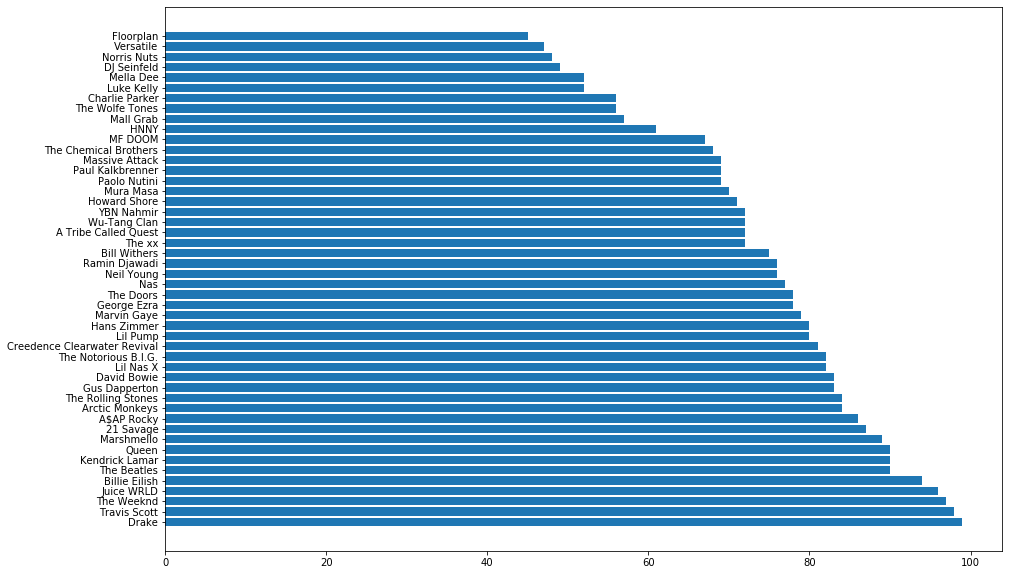

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(artists.name, artists.popularity)

# Scrape Artist Ethnicity
https://ethnicelebs.com/

In [4]:
# from bs4 import BeautifulSoup as bs4
# import requests

## Scrape all paragraphs on page

In [5]:
# def get_paragraph(artist_name):
#     headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
#     base_url = "https://ethnicelebs.com/"
    
#     # Parsed artists name
#     parse_name = artist_name.replace(" ", "-")
#     req = requests.get(base_url+parse_name, headers=headers)
#     soup = bs4(req.content, "html.parser")

#     # Find all <p> elements
#     para = str(soup.find_all('p'))

#     # Find range of string
#     string_start = para.find("Ethnicity: ") + len("Ethnicity: ")
#     string_end = para.find("</strong")
#     race = para[string_start:string_end]
    
#     if len(race) < 100:
# #         return 'Artist: '+artist_name+'\nRace: '+ race
#         return race


&nbsp;
### Add races for each artist in df
Using BeautifulSoup is really slow.

In [6]:
# # Iterate over names and scrape
# races = []
# for artist in artists.name:
#     races.append(get_paragraph(artist))

In [7]:
# # Convert to Pandas Series and add to df
# artists_races = pd.Series( v for v in races )    
# artists['race'] = artists_races
# artists.head(5)

#### Plot specific races
This plot has many specific races which gives a very messy graph. Grouping the ethnicities and removing the None values would be an improvement

In [8]:
# fig, ax = plt.subplots(figsize=(22,7))
# artists.plot.barh(x ='race', y='popularity', ax=ax)

&nbsp;
### Group ethnicities
- The artists not found from scraping are 'Unknown
- Some *assumptions* for the other races

In [9]:
# artists.race.loc[ artists.race.isnull() == True ] = 'Unknown'
# artists.race.loc[ artists.race.str.contains('English|Irish|Jewish') == True ] = 'White'
# artists.race.loc[ artists.race.str.contains('African|Black|Ethiopian') == True ] = 'Black'

#### Plot grouped races
- count() prevents popularity playing a role in the numbers
- unstack() breaks the groupby into further groups (not sure)

In [10]:
# fig, ax = plt.subplots(figsize=(15,7))

# # Group and plot
# artists.groupby('race').count().unstack().popularity.plot.bar(ax=ax)

&nbsp;
# ScraPy Efficient Scraping
BeautifulSoup was useful for starting off with scraping but it is pretty slow. ScraPy requires a little more setup but supports asynchrony making it a lot faster.

### Defining the Spider
A spider in ScraPy is a class written in Python to define the way data will be searched and parsed on the website.

In [3]:
import scrapy
from scrapy.crawler import CrawlerProcess

class EthnicCelebSpider(scrapy.Spider):
    """Scrapes ethnic celebs website using XPath selector"""
    name = "ethnic_celebs"

#     def __init__(self, artist='', **kwargs):
    def __init__(self, artists=[], **kwargs):
        """Takes artist as an argument when called"""
        for artist in artists:
        # Replaces spaces with "-" for website
            artist = artist.replace(" ", "-")
            print(artist)
            self.start_urls.append([f'https://ethnicelebs.com/{artist}'])
        
    def parse(self, response):
        """Get artist race"""    
        if response.status != 404:
            next_page = response.xpath('/html/body/div/div/div/div/div/section/div[2]/article/div/div[2]/div[1]/p[4]/strong/text()').get()
            # Find word and exclude
            string_start = next_page.find("Ethnicity: ") + len("Ethnicity: ")
            race = next_page[string_start:len(next_page)]
        else:
            race = 'Unknown'
        
        print('\n'+race+'\n')
        return race

### Crawl for 21 Savage

In [4]:
# Setup scraper
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36' 
})

# Instantiate class and pass artist
process.crawl(EthnicCelebSpider, artists=['21 savage', 'kanye west'])
# process.crawl(EthnicCelebSpider, artist='21 savage')
process.start()

2020-06-23 09:43:51 [scrapy.utils.log] INFO: Scrapy 2.1.0 started (bot: scrapybot)
2020-06-23 09:43:51 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 18.9.0, Python 3.8.2 (default, Apr 27 2020, 15:53:34) - [GCC 9.3.0], pyOpenSSL 19.0.0 (OpenSSL 1.1.1f  31 Mar 2020), cryptography 2.8, Platform Linux-5.4.0-37-generic-x86_64-with-glibc2.29
2020-06-23 09:43:51 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-06-23 09:43:51 [scrapy.crawler] INFO: Overridden settings:
{'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
               '(KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}
2020-06-23 09:43:51 [scrapy.extensions.telnet] INFO: Telnet Password: c9a05658b487bfd0
2020-06-23 09:43:51 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.Mem

21-savage


### Use Spider with DataFrame

In [3]:
# Setup scraper
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36' 
})

# for artist in artists.name:
# Instantiate class and pass artist
process.crawl(EthnicCelebSpider, artists=artists.name)
process.start()

2020-06-23 09:41:49 [scrapy.utils.log] INFO: Scrapy 2.1.0 started (bot: scrapybot)
2020-06-23 09:41:49 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 18.9.0, Python 3.8.2 (default, Apr 27 2020, 15:53:34) - [GCC 9.3.0], pyOpenSSL 19.0.0 (OpenSSL 1.1.1f  31 Mar 2020), cryptography 2.8, Platform Linux-5.4.0-37-generic-x86_64-with-glibc2.29
2020-06-23 09:41:49 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor


NameError: name 'artists' is not defined

&nbsp;
## Defining the Wikipedia Spider
After looking at some of the artists on Wikipedia, spaces in the URL seems to be filled with underscores-as opposed to dashes in ethniccelebs.

In [14]:
import scrapy
from scrapy.crawler import CrawlerProcess

class WikiSpider(scrapy.Spider):
    """Scrapes ethnic celebs website using XPath selector"""
    name = "wiki"

    def __init__(self, artist='', **kwargs):
        """Takes artist as an argument when called"""
        # Replaces spaces with "_" for website
        artist = artist.replace(" ", "_")
        self.start_urls.append([f'https://wikipedia.com/wiki/{artist}'])

    def parse(self, response):
        """Get artist race"""    
        if response.status != 404:
            # 21 Savage XPath
#             res = response.xpath('/html/body/div[3]/div[3]/div[4]/div/table[1]/tbody/tr[5]/td/span[2].text()').get()
            res = response.css('."noprint ForceAgeToShow" span::text').get()
            # Find word and exclude
            string_start = res.find("age ") + len("age ")
            age = res[string_start:len(res)]
        else:
            age = 'Unknown'
        
        print('\n'+age+'\n')
        return age
    
# Setup scraper
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

# Instantiate class and pass artist
process.crawl(WikiSpider, artist='21 Savage')
process.start()

Unhandled error in Deferred:
Temporarily disabling observer LegacyLogObserverWrapper(<bound method PythonLoggingObserver.emit of <twisted.python.log.PythonLoggingObserver object at 0x7f6e2bd01eb0>>) due to exception: [Failure instance: Traceback: <class 'TypeError'>: _findCaller() takes from 1 to 2 positional arguments but 3 were given
/usr/lib/python3.8/tokenize.py:528:_tokenize
/usr/lib/python3/dist-packages/twisted/internet/defer.py:953:__del__
/usr/lib/python3/dist-packages/twisted/logger/_logger.py:270:critical
/usr/lib/python3/dist-packages/twisted/logger/_logger.py:144:emit
--- <exception caught here> ---
/usr/lib/python3/dist-packages/twisted/logger/_observer.py:131:__call__
/usr/lib/python3/dist-packages/twisted/logger/_legacy.py:93:__call__
/usr/lib/python3/dist-packages/twisted/python/log.py:595:emit
/usr/lib/python3/dist-packages/twisted/logger/_legacy.py:154:publishToNewObserver
/usr/lib/python3/dist-packages/twisted/logger/_stdlib.py:115:__call__
/usr/lib/python3.8/loggin